<h1 style="color:green"> House Prices: Advanced Regression Techniques  </h1>

<h3 style="color:blue"> Summary : </h3>

    House price is a kaggle competition which is based on predicting house price from
    different features of house using machine learning techniques. The following processes
    are done for solving the house price prediction problem.
    1. Data is preprocessed by following steps-
        - 2.0 Correlation Analysis
        - 2.1 Outlier handling
        - 2.2 Missing value Handling
        - 2.3 Catagorical to numerical conversion
        - 2.4 Unskewing while needed 
        - 2.5 Data scaling.
    2. Each preprocessing step's effectiveness is checked by simple linear regression
    as ANN takes long time to train.
    3. Hyperparameter was tuned by manual experiments. Comparative graph plots of each of these
    experiments are shown below at hyperparameter tuning section.
    4. Some of the hyperparameter (Optimizer ,activation funtion) decisions were taken with 
    gird search, code for grid search is added in grid search section.
    Hyperparameter tuning was done with following steps-
         -4.1 Layer Optimization
         -4.2 Optimizer grid search (Each optimizer for learning rates and epochs)
         -4.3 Learning Rate Optimization
         -4.4 Epochs, Early stopping, Regularization constan optimization.
         -4.5 Activation optimazation
         -4.6 Batch size optimization
    5. Grid-Search with cross validation was very much time expensive, Cross validation was done
        after hyperparameter tuning the and validation error was not varying that much for all the 
        3-folds. Code for cross validation is added at cross validation section.
    6. Model was trained with the tuned hyperparameters and results were submitted at
    kaggle.com. Screenshots of results is shown at the end of the report at results section.

<h3 style="color:blue"> 1.0 Importing libraries </h3>
    
1. Pandas
2. Numpy
3. Scipy
4. Sklearn
5. Tensorflow

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew,norm
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

<h3 style="color:blue">  1.1 Utility functions </h3>

    1. 'get_feat_count' Function for feature count 
    -input : data
    -output : catagorized feature list (catagorical,numeric,continuous,discrete)
    2. 'get_corr_list' Function for sorting based on correlation with target feature, including 
    ordinal/label encoding support for correlation determining of ordinal or nominal 
    features. 
    -input : data 
    -output : sorted correlation , correralted feat list

In [2]:
def get_feat_count(all_data):
    num_feat = all_data.dtypes[all_data.dtypes != "object"].index
    con_feat=[]
    dis_feat=[]
    for feat in num_feat:
        uniq=all_data[feat].unique()
        if len(uniq)>20:
            con_feat.append(feat)
        if len(uniq)<=20:
            dis_feat.append(feat)
    cat_feat = all_data.dtypes[all_data.dtypes == "object"].index
    return num_feat,cat_feat,con_feat,dis_feat
def get_corr_list(_data,_feat,thr,enc):
    all_obj_data=_data.loc[:len(train),_feat].copy()
    all_obj_data['SalePrice']=train['SalePrice']
    target='SalePrice'
    if enc=='ord_enc':
        for feat in _feat:
            ordered_labels = all_obj_data.groupby([feat])[target].mean()
            ordered_labels=ordered_labels.sort_values().index
            ordinal_label = {}
            for i, k in enumerate(ordered_labels, 0):
                ordinal_label[k]=i
            #print(ordinal_label)
            all_obj_data.loc[:,feat]=all_obj_data.loc[:,feat].map(ordinal_label)
    
    if enc=='lbl_enc':
        for col in _feat:
                lbl = LabelEncoder()
                lbl.fit(list(all_obj_data[col].values))
                all_obj_data[col] = lbl.transform(list(all_obj_data[col].values))

    corrmat = all_obj_data.corr()
    corrmat['corr_value']=corrmat['SalePrice'].abs()
    corrmat1=corrmat.sort_values( by=['corr_value'],ascending=False)
    cm=(corrmat1['corr_value'].abs())
    cm=pd.DataFrame(cm)
    corr_cols=list(cm[cm['corr_value']>thr].index)
    corr_cols=corr_cols[1:]
    
    return cm,corr_cols

<h3 style="color:blue"> 2.0  Correlation analysis </h3>

1. Analysing correlation 
2. Ploting the result for the features having high correlation with sale price 


In [3]:
def read_data():
    train = pd.read_csv("train.csv")
    test = pd.read_csv("test.csv")
    train.drop("Id",axis =1,inplace = True)
    test.drop("Id",axis =1,inplace= True)
    print('reading data done...')
    return train,test
def concate_data(train,test):
    all_data = pd.concat((train.loc[:, 'MSSubClass': 'SaleCondition'],test.loc[:,'MSSubClass':'SaleCondition']),ignore_index=True)
    print("all_data size is: {} ".format(all_data.shape))
    print('Concating data done ...')
    return all_data

reading data done...
             corr_value
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581


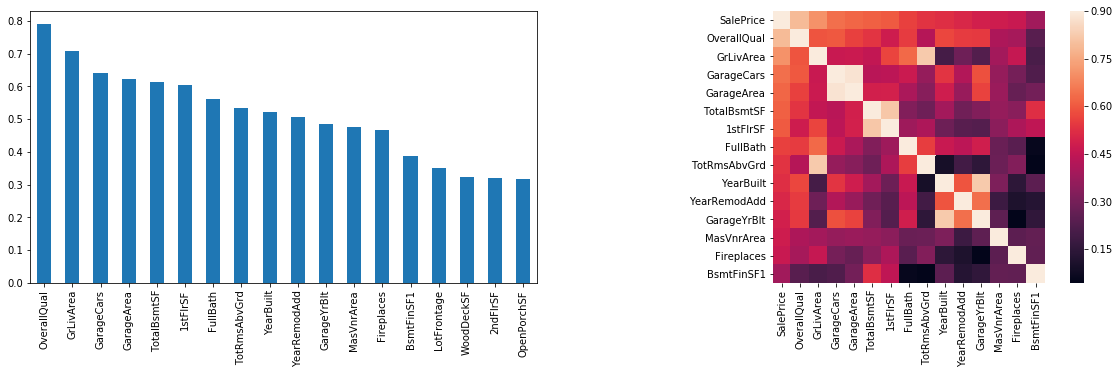

In [4]:
train,test=read_data()
data=train.copy()

num_feat,cat_feat,con_feat,dis_feat=get_feat_count(data)
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,5))

cm,corr_cols=get_corr_list(data,num_feat,0.3,enc='none')
cm.drop(['SalePrice'],inplace=True)
print(cm.head(5))
cm['corr_value'][cm['corr_value']>0.3].plot.bar(ax=axes[0])
#sns.pairplot(all_data[corr_cols[:4]])
#plt.show()
corr_cols=['SalePrice']+corr_cols
sns.heatmap(data[corr_cols[:15]].corr(),vmax=0.9, square=True,ax=axes[1])
plt.show()

<h3 style="color:blue"> Observetaions
    
##### Features below are highly correlated with sale price.<br>
'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd',<br>
'YearBuilt' ,'YearRemodAdd' ,'GarageYrBlt' ,'MasVnrArea', Fireplaces' <br> 

##### Some pairs are internally correlated. This property can be used for missing value replacement.
1. 'GarageCars','GarageArea'<br>
2. 'TotalBsmtSF','1stFlrSF'<br>
3. 'FullBath','TotRmsAbvGrd'<br>
4. 'YearBuilt','YearRemodAdd','GarageYrBlt'<br>


<h3 style="color:blue">  2.1 Handling Outlier </h3>

    1. Some of the features having high correlaion with target feature contain outliers
    2. Remoiving outliers reduces error for only GrLivArea,TotalBsmtSF  

In [5]:
def remove_outlier(train):
    train = train.drop(train[(train['GrLivArea']>4000)].index)
    train = train.drop(train[train['TotalBsmtSF']>6000].index)
    #train = train.drop(train[train['LotArea']>100000].index)
    train=train.reset_index()
    print('removing oulier done...')
    return train

reading data done...
removing oulier done...
all_data size is: (2915, 79) 
Concating data done ...


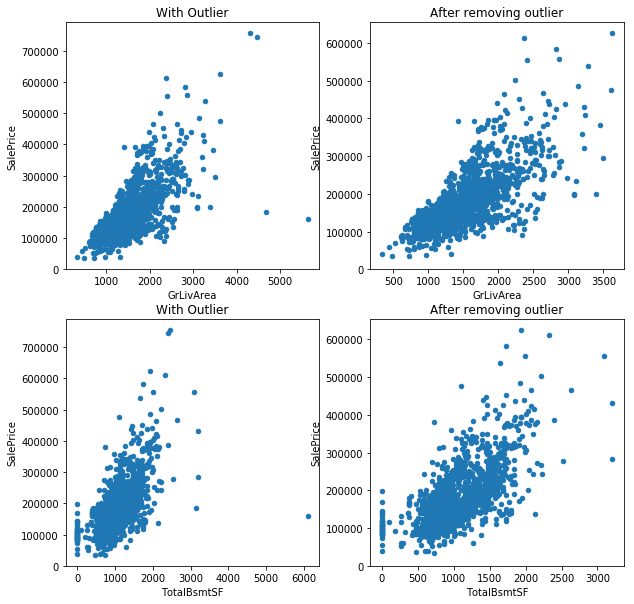

In [6]:

train,test=read_data()
cols=['GrLivArea','TotalBsmtSF']#','LotArea']

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
for i in range(2):
    train.plot.scatter(x=cols[i], y='SalePrice', ylim =10,ax=axes[i,0]);axes[i,0].set_title('With Outlier');
train=remove_outlier(train)
all_data=concate_data(train,test)
for i in range(2):
    train.plot.scatter(x=cols[i], y='SalePrice', ylim =10,ax=axes[i,1]);axes[i,1].set_title('After removing outlier');
plt.show()

<h3 style="color:blue"> 2.1.1 Target feature Analysis </h3>

1. Target feature scewness ploting
2. Deviation from normalized distribution is observed
3. log applied for unscewing
4. plotting after unscewing

all_data size is: (2915, 79) 
Concating data done ...


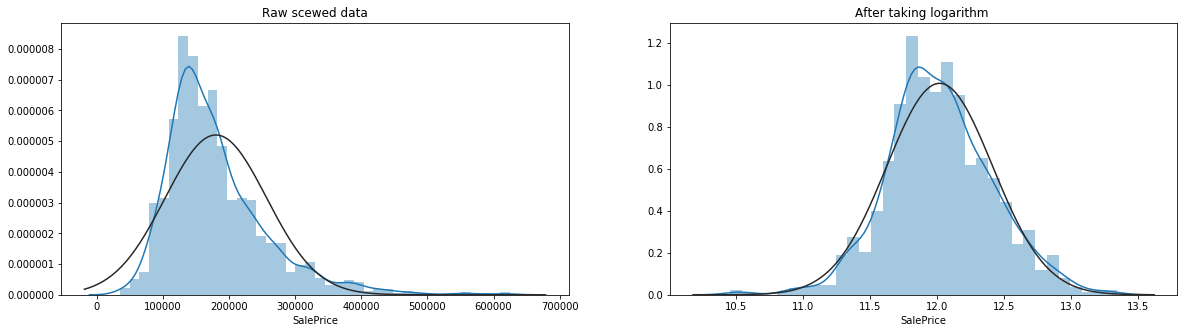

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,5))
sns.distplot(train.SalePrice,fit=norm,ax=axes[0]); axes[0].set_title('Raw scewed data');


def unscew_target(train):
        train["SalePrice"] = np.log1p(train["SalePrice"])
        return train
#uc_train=train.copy()
train=unscew_target(train)
uc_all_data=concate_data(train,test)
sns.distplot(train.SalePrice,fit=norm,ax=axes[1]); axes[1].set_title('After taking logarithm ');
plt.show()

<h3 style="color:blue"> 2.2 Missing value analysis </h3>

1. Missing value counting 
2. sorting by descending order of % missing value
3. Catagorizing Sorted features  

<h3 style="color:blue"> Function 'missing_status' </h3>

 _Input:_  Data <br>
 _Output:_
>1. Dataframe with missing value percentage of each feature in descending order of missing value percentage.<br>
>2. Separate lists of numeric, catagorical features containing missing values in descending order

In [8]:
def missing_status(all_data):
    all_data_na = (all_data.isnull().sum()/ len(all_data)) * 1
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index)
    all_data_na=all_data_na.sort_values(ascending = False)
    missing_data =pd.DataFrame({'Miss_ratio':all_data_na[all_data_na>0.0]})
    miss_cols=list(missing_data.index)
    num_feat,cat_feat,con_feat,dis_feat=get_feat_count(all_data)
    i=0
    m_cat_feat=[]
    m_con_feat=[]
    m_dis_feat=[]
    m_all=[]
    for col in miss_cols:
        if col in cat_feat:
            m_cat_feat.append(col)
            m_all.append('catagorical')
        if col in con_feat:
            m_con_feat.append(col)
            m_all.append('continuous')
        if col in dis_feat:
            m_dis_feat.append(col)
            m_all.append('discrete')
        i=i+1
    missing_data['type']=m_all    
    return missing_data,m_cat_feat,m_con_feat,m_dis_feat


catagorical feat 43  missing value present in 23
numeric feat     36  missing value present in 11
continuous feat  21  missing value present in 8
discrete feat    15  missing value present in 3


Plot of missing value in descending order of their count :


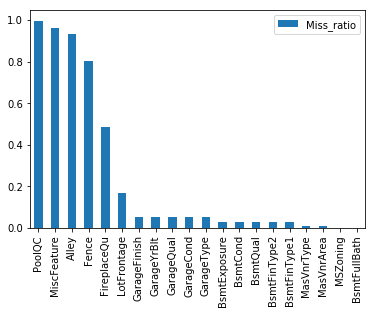

In [9]:
num_feat,cat_feat,con_feat,dis_feat=get_feat_count(all_data)
miss_data,m_cat_cols,m_con_cols,m_dis_cols=missing_status(all_data)
print('catagorical feat',len(cat_feat),' missing value present in',len(m_cat_cols))
print('numeric feat    ',len(num_feat),' missing value present in',len(m_con_cols)+len(m_dis_cols))
print('continuous feat ',len(con_feat),' missing value present in',len(m_con_cols))
print('discrete feat   ',len(dis_feat),' missing value present in',len(m_dis_cols))
print('\n\nPlot of missing value in descending order of their count :')
miss_data[:20].plot.bar()
plt.show()

### _Observations_
Both Catagorical and Numarical feature contains significant number of features having missing values so they will be plotted separately for analysis.

#### Plotting Numeric features(Left) , Catagorical Features(Right) :In descending order of correlation with sale price
1. Bar plot indicates missing ratio in percentage(0.0-1.0)
2. line plot is the measure of correlation with target feature in range (0.0,1.0)
It helps to find the highly correlated columns having missing value


In descending order of correlation
1. bar plot is for missing ratio 
2. line plot is for correlation


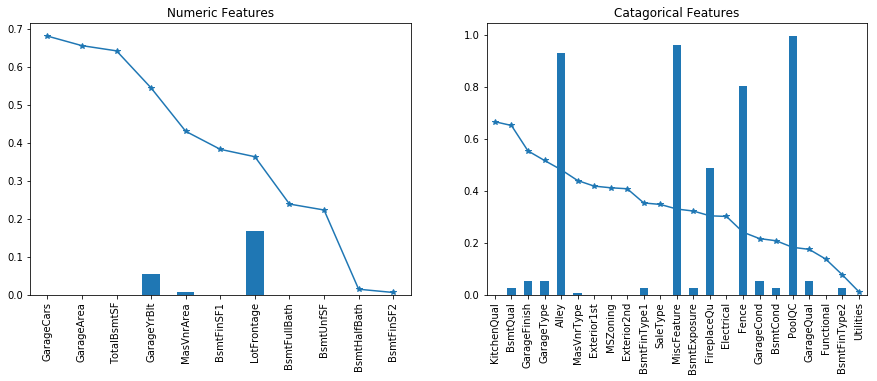

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))

cm,corr_feat=get_corr_list(all_data,m_con_cols+m_dis_cols,thr=0,enc='none')
cm['miss_ratio']=0
for feat in corr_feat:
    cm.loc[feat,'miss_ratio']=miss_data.loc[feat,'Miss_ratio']
cm.drop(['SalePrice'],inplace=True)

print('In descending order of correlation\n1. bar plot is for missing ratio \n2. line plot is for correlation')
cm['corr_value'].plot(marker='*',ax=axes[0]);axes[0].set_title('Numeric Features');
cm['miss_ratio'].plot.bar(ax=axes[0]);



cm,corr_feat=get_corr_list(all_data,m_cat_cols,thr=0.0,enc='ord_enc')
cm['miss_ratio']=0
for feat in corr_feat:
    cm.loc[feat,'miss_ratio']=miss_data.loc[feat,'Miss_ratio']
cm.drop(['SalePrice'],inplace=True)
cm['corr_value'].plot(marker='*',ax=axes[1]);axes[1].set_title('Catagorical Features');
cm['miss_ratio'].plot.bar(ax=axes[1]);
plt.show()

### Findings from the above plot
    1. Here 'LotFrontage', 'GarageYrBlt','TotalBsmtSF','MasVnrArea' seems to be important and 
    will be considered specially during handling missing values
    2. Here 'PoolQual', 'Alley', 'MiscFeature' seems to have high missing value but correlated 
    resonably and will be considered specially during missing values.
    3. Among these features 'KitchenQual','Exterior1st','Exterior2nd','SaleType','Electrical',
    'MSZoning' these features are must for house so cannot be none or zero so they can be 
    replaced by mode value instead.


### Function "_Handling missing values_"
     from the plot of the numerical features with missing values it was found that 
     'LotFrontage', 'GarageYrBlt','TotalBsmtSF', 'MasVnrArea' have high correlation
    1. 'LotFrontage' is replaced by median value of neighbourhood as houses having same 
    neighbourhood have probability having same lotFrontage (I have found this information 
    while reading about the data somewhere in internet)
    2. 'GarageYrBlt' is replaced by zeero as no year built means no garage but another feture 
    naming GarageYrBlt is created for compensation
    3. 'TotalBsmtSF' , '1stFlrSF', '2ndFlrSF' is replaced by zero but another feature naming 
    'TotalSF' is added to compensate for the missing values
    4. 'PoolQual', 'Alley', 'MiscFeature' have hign  missing value with resonably high correlation 
    so dropping them was not a good idea at all but having no 'PoolQual' means no pool at all so
    they are replaced by 'Missing' label.
    5. 'KitchenQual','Exterior1st','Exterior2nd','SaleType','Electrical','MSZoning'  are replaced 
    by mode value the reason was explained earlier.
    6. Rest of the continuous values are replaced by zero.
    7. Rest of the catagirical values are replaed by 'Missing' label.


In [11]:

def handle_missing_values_new(data,m_cat_cols,m_con_cols,m_dis_cols):
    mode_cols=['MSZoning','KitchenQual','Exterior1st','Exterior2nd','SaleType','Electrical']
    for col in mode_cols:
        data[col] = data[col].fillna(data[col].mode()[0])

    
    data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
    
    data['GarageYrBlt'].fillna(data.YearBuilt)
    data['GarageYrBlt_NA'] =np.array(data['GarageYrBlt']>0)
    
    zero_cols=['TotalBsmtSF','1stFlrSF','2ndFlrSF']
    for col in zero_cols:
        data[col] = data[col].fillna(0)
    
    data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
    data['Remodified'] = np.int8(data['YearRemodAdd'] > data['YearBuilt'])
    #data=data.drop(columns=['Utilities'],axis=1)
    
    for col in m_cat_cols:
        data[col] = data[col].fillna('None')
    for col in m_con_cols:
        data[col] = data[col].fillna(0)
    for col in m_dis_cols:
        data[col]=data[col].fillna(0)
    print('Missing values handling done ...')
    return data
data=uc_all_data.copy()
no_miss_data=handle_missing_values_new(data,m_cat_cols,m_con_cols,m_dis_cols)

Missing values handling done ...


<h3 style="color:blue"> 2.3 Scewed Feature Handling : BoXCoX and Log Transform </h3>

    1.Getting scewness of the numeric features
    2.Unscewing numeric features having high scew values
     According to scipy official doccumetation
    BoxCoX ransform:
    lambda>0 : y = (x**lmbda - 1)
    lambda=0 : log(x)
    
##### For lambda= 0.0 (log transform)
    Mean MSLE 0.012509277505700179
    Mean RMSLE 0.11184488144613583
    Mean R2 Correlation 0.9204481800996724
#### For lambda =0.10
    Mean MSLE 0.012368725963561606
    Mean RMSLE 0.11121477403457512
    Mean R2 Correlation 0.921346189494867
#### For lambda=0.20
    Mean MSLE 0.01226936107188475
    Mean RMSLE 0.11076714798118055
    Mean R2 Correlation 0.9219891391697006
#### For lambda=0.30 *** best one
    Mean MSLE 0.012210948878665508
    Mean RMSLE 0.11050316230165319
    Mean R2 Correlation 0.9223752236486487
#### For lambda =0.50
    Mean MSLE 0.012216367783911775
    Mean RMSLE 0.11052767881355229
    Mean R2 Correlation 0.9223718674166298
As lambda=0.20 performed better so i used this.

In [12]:
def get_skewness(skewed_data,feats,thr,sort=True):
    sk_df=skewed_data[feats].skew().abs()
    if sort==True:
        sk_df=sk_df.sort_values(ascending=False)
    #sk_df = skewed_data[feat].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)
    sk_df=pd.DataFrame({'Skew' :sk_df}) 
    sk_df.head(5)
    sk_cols=sk_df#[sk_df.Skew>thr]
    sk_cols=sk_cols.index.values.tolist()  
    return sk_cols,sk_df
def unscew_features(sk_data,sk_cols):
    from scipy.special import boxcox1p
    lam = 0.30
    for feat in sk_cols:
        sk_data[feat] = boxcox1p(sk_data[feat], lam)
    return sk_data

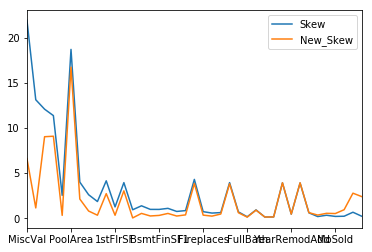

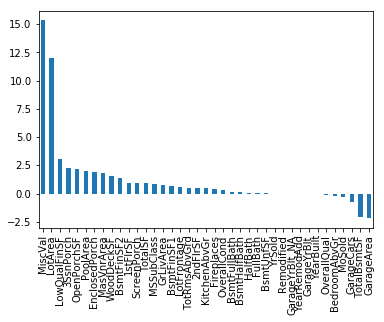

In [13]:
unskewed_data=no_miss_data.copy()
num_feat,cat_feat,con_feat,dis_feat=get_feat_count(unskewed_data)

sk_cols,sk_df=get_skewness(unskewed_data,num_feat,0.75,sort=False)


unskewed_data=unscew_features(unskewed_data,sk_cols)
_,_sk_df=get_skewness(unskewed_data,num_feat,0.75,sort=False)

sk_df['New_Skew']=_sk_df['Skew']
sk_df['Diff']=sk_df['Skew']-sk_df['New_Skew']
sk_df.sort_values(by=['Diff'],inplace=True,ascending=False)
sk_df[['Skew','New_Skew']].plot()
plt.show()
sk_df['Diff'].plot.bar()
plt.show()
sk_cols=sk_df.index.values.tolist()

### _Restoring the last 5 features for which skewness was not rduced after BoxCoX transform_

In [14]:
neg_cols=sk_df.tail(5).index.tolist()
unskewed_data[neg_cols]=no_miss_data[neg_cols]

### _Plot of Some features fit with normaml distribution before and after unscewing_
1. For some of the features like

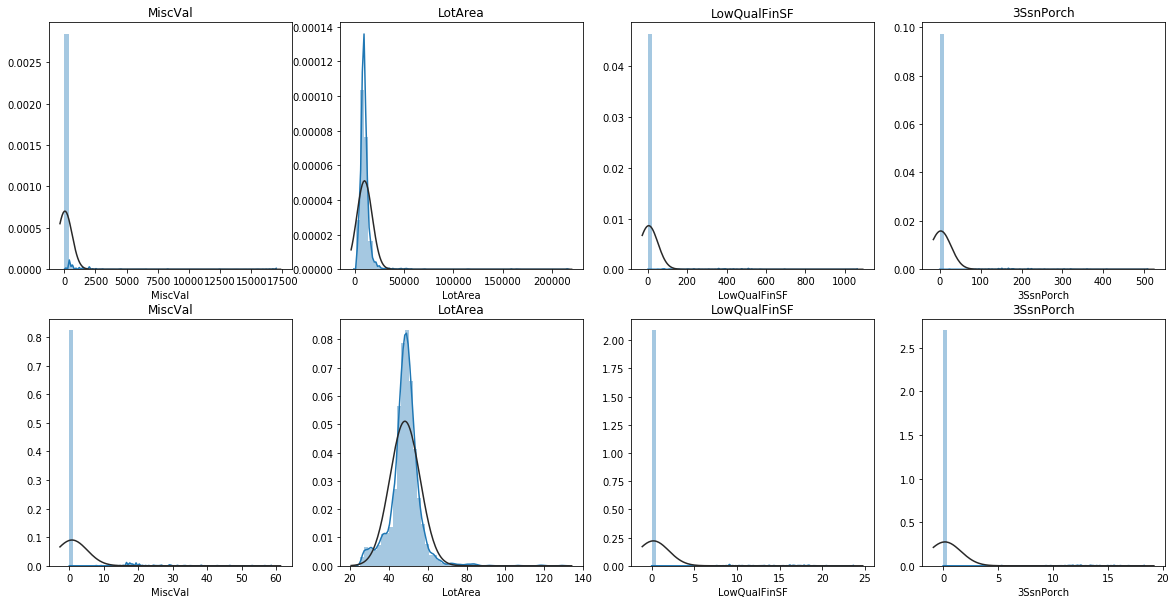

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=4,figsize=(20,10))
for i in range(0,4):
    sns.distplot(no_miss_data[sk_cols[i]],fit=norm,ax=axes[0,i]); axes[0,i].set_title(sk_cols[i]);
for i in range(0,4):
    sns.distplot(unskewed_data[sk_cols[i]],fit=norm,ax=axes[1,i]); axes[1,i].set_title(sk_cols[i]);

### 2.4  _Catagorical data encoding experiments_

    1. Ordinal Encoding:
    Many of the features are ordinal here i.e poor,fair,good,excelent this kind of ranked. So they 
    were labeled by order of the mean value of sale price. But replacing with equally spaced 
    integers i.e poor-0,good-1 made the intervel of poor and good forcely imposed to 1. So I 
    considered to 

    {'Po': 0.0, 'Fa': 1.0, 'TA': 2.0 'Gd': 3.0, 'Ex': 4.0}

    --replace the labels with their mean sale price 
    --MinMax Scalered the labels from 0-1
    --Multiplied them by number of ranks i.e (poor,good,fair,excellent total 4)
    Here interval between Poor and Fair is 1.51 instead of 1 and 1.51 is proportional to 
    difference of saleprice mean which is more resonable.

    {'Po': 0.0, 'Fa': 1.51, 'TA': 2.48, 'Gd': 2.9, 'Ex': 5.0}

    ordinal encoding showed high correlation which will be shown in some plots below. It 
    showed good result for cross validation error based on splits of train data but resulted
    poor for test data submited in kaggle.

    2.Random Label Encoding:Random number label encoding was also not that good, Random number 
    encoding was done using scikit learns label encoder which encodes labels by alpha-numeric
    order that is kind of random.
    3.Binary Encoding:Binary Encoding was tried for less number of features than One-Hot but 
    was not that good. A Library named Catagory encoders was used for binary encoding.
    4.One-Hot Encoding: Finally One-Hot encoding was done which performd best as many of the 
    features are nominal. It resulted in 306 number of features and worked best.
##### Some of the plots of ordinal encoding are still presented here for showing the correlations.

In [16]:
def ordinal_encode(_data,cols):
    data=_data.copy()
    for feat in cols: 
        dt_grp=train.groupby(feat)['SalePrice'].mean()
        dt_srt=(dt_grp.sort_values())
        dt_rsp=(np.array(dt_srt).reshape(len(dt_grp),1))
        rb=MinMaxScaler()
        dt_scl=rb.fit(dt_rsp).transform(dt_rsp)*len(dt_rsp)
        dt_scl=np.round(dt_scl,2)
        map_dict={}
        i=0
        indx=dt_srt.index
        for lb in indx:
            map_dict[lb]=dt_scl[i,0]   
            i+=1
        _data[feat]=_data[feat].map(map_dict)
        print(feat,':',map_dict)
    return _data

GarageFinish : {'Unf': 0.0, 'RFn': 2.14, 'Fin': 3.0}
GarageType : {'CarPort': 0.0, 'Detchd': 1.35, '2Types': 2.36, 'Basment': 2.5, 'Attchd': 4.33, 'BuiltIn': 6.0}
Foundation : {'Slab': 0.0, 'BrkTil': 1.57, 'CBlock': 2.79, 'Stone': 3.31, 'Wood': 4.71, 'PConc': 6.0}
FireplaceQu : {'Po': 0.0, 'Fa': 1.51, 'TA': 2.48, 'Gd': 2.9, 'Ex': 5.0}
HeatingQC : {'Po': 0.0, 'Fa': 1.59, 'TA': 2.66, 'Gd': 3.23, 'Ex': 5.0}
MasVnrType : {'BrkCmn': 0.0, 'None': 0.26, 'BrkFace': 2.13, 'Stone': 4.0}


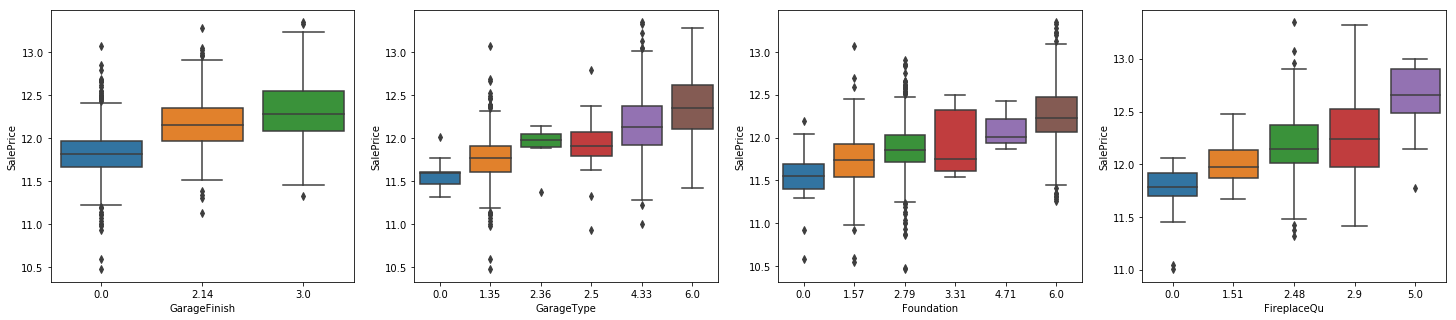

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(25,5))
enc_data=unskewed_data.copy()

num_feat,cat_feat,con_feat,dis_feat=get_feat_count(enc_data)
cm,corr_feat=get_corr_list(enc_data,cat_feat,thr=.3,enc='ord_enc')

ord_feat=['ExterQual','KitchenQual','BsmtQual','GarageFinish','FireplaceQu',
        'HeatingQC','GarageCond','BsmtFinType1','BsmtExposure','CentralAir']

enc_data=ordinal_encode(enc_data,corr_feat[4:10])
plt_enc_data=enc_data.copy()
plt_enc_data['SalePrice']=train.SalePrice
n=3
for j in range(4):
        n+=1
        sns.boxplot(x=corr_feat[n], y='SalePrice', data=plt_enc_data,ax=axes[j])

plt.show()

### 2.5 _Scaling and One-Hot Encoding_
    - One Hot Encoding is done here.
    - Robust scalar performed best among (RobustScalar,MInMax Scalar,Standard Scalar)
    1. MinMax Scalar:
    It scales the data between 0.0-1.0 by using the following formula<br>
    >(xi–min(x))/ (max(x)–min(x))
        Mean MSLE 0.014089412804525631
        Mean RMSLE 0.11869883236378373
        Mean R2 Correlation 0.9105597120051453
    2. Standard Scalar:
    It scales the data by using the following formula
    >(xi–mean(x))/stdev(x)
        Mean MSLE 0.01378825640326525
        Mean RMSLE 0.11742340653917877
        Mean R2 Correlation 0.9121997077452753
    3. Robust Scalar:
    It is different from minmax scaler in the way that it takes inter quartiile range as the 
    range of scaling. As outliesr are mostly stays out of the IQR range it helps to handle 
    data with outlier. It scales the data by using the following formula.<br>
    >(xi–Q1(x))/( Q3(x)–Q1(x))
        Mean MSLE 0.012210948878665508
        Mean RMSLE 0.11050316230165319
        Mean R2 Correlation 0.9223752236486487

In [18]:
scl_data=unskewed_data.copy()
print(scl_data.shape)
scl_data.replace(np.nan,0,inplace=True)
scl_data.replace(np.inf,0,inplace=True)
scl_data=scl_data.fillna(0)
scl_data = pd.get_dummies(scl_data)
print(scl_data.shape)
#print(sc_data[cc].head(3))
robust_scaler = RobustScaler()
scl_data = robust_scaler.fit(scl_data).transform(scl_data)

(2915, 82)
(2915, 306)


### _Preprocessing steps Vs Error_   
     The plot below shows rmsle after adding each preprocessing step.
![title](img/rmsle_df.png)<br>

### 3.0 Separating test and train data which were concated for preprocessing.

In [19]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train= train.SalePrice.values
_train = pd.DataFrame(scl_data[:ntrain])
_test = pd.DataFrame(scl_data[ntrain:])

### 3.3 _Linear Regression block used for checking error for each additional steps of data processing_ 

In [20]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

regr=linear_model.Ridge(alpha=8)
regr.fit(_train.values,y_train)
#res=regr.predict(np.array(_test.values))

score1=cross_val_score(regr, _train.values, (y_train), scoring="neg_mean_squared_error",cv = 10)
score2=cross_val_score(regr, _train.values, y_train, scoring="r2",cv = 10)
msle=np.abs(score1.mean())
rmsle=np.sqrt(msle)
r2_corr=score2.mean()
print('Mean MSLE',msle)
print('Mean RMSLE',np.sqrt(msle))
print('Mean R2 Correlation',score2.mean())
[msle,rmsle,r2_corr]

Mean MSLE 0.012196363423599334
Mean RMSLE 0.11043714693706704
Mean R2 Correlation 0.9224937146777661


[0.012196363423599334, 0.11043714693706704, 0.9224937146777661]

### 4.0 _Hyperparameter Tuning and deciding network architecture_
#### For Each of these hyperparameter tuning all the others were kept constant. 

    Hyper parameter tuning was done for 
    -train data 66.67%
    -validation data 33.33%
    


#### Steps:

    4.1 Layer Optimization
    4.2 Optimizer grid search
    4.3 Learning Rate Optimization
    4.4 Epochs, Early stopping, Regularization constan optimization.
    4.5 Activation optimazation
    4.6 Batch size optimization

### 4.1 _Layer Optimization_
    
    Following Graphs show relation of Layers and learning rate with error and convergence.
    1. One layer was under fitting
    2. Two Layer fitted properly
    3. Three Layer over fitted.
![title](img/_layer_1.png)
![title](img/layer_2.png)

### 4.2 _Optimizer_ -Grid Search
    1. The goal of this section is primarily finding a optimizer with roughly selecting 
    a best learning rate and epoch for that optimizer.
    2. Learning rate and epoch will be further analysed with detailed learning curve in 
    their correspondig sections.
    
    Set of values of hyperparameters for testing-
    
         -Optimizers -    [GradientDescent , Adagrad , Adadelta , RMSprop , Adam]
         -Learning rate - [0.0001,0.001,0.01]
         -Epochs -        [500,1000,1500]
        
        -As grid search of this 5*3*3=45 combinations is really time consuming.
        -It is also hard to interpret their mutual effects on error in single plot of all 45 
        combinations,
        -So I have divided the process into 3 steps totaling 5*3 + 5*3 =30 combinations.
        
        Step 1 - All combination of optimizers and learning rates is searched with constant - 
        1000 epoch (Epoch will be searched in step 3.) (5*3=15 combinations)
        
        Step 2 - Each Optimizers with its best learing rate found from step 1 is plotted for 
        finding best Optimizer. 
        
        Step 3 - Optimizers with best learning rates found from setp 1 is plotted for 
        [500,1000,1500] epochs for considering improvements with epochs and reconfirming the best
        optimizer found from step 2 is still better with different epochs. (5*3=15 combinations)
        
#### Step 1 : Optimizer-learning rate               
            -Optimizers -    [GradientDescent , Adagrad , Adadelta , RMSprop , Adam]
            -Learning rate - [0.0001,0.001,0.01]
            -Epochs -        [1000]
            
![title](img/opt_lr_1.png)<br>

#### Step 1 : observations :
        
            Optimizer         Best laerning rate
            ---------         ------------------
            GradientDescent   Learning Rate-0.0001  
            Adagrad           Learning Rate-0.01  
            Adadelta          Learning Rate-0.01 
            RMSprop           Learning Rate-0.0001 
            Adam              Learning Rate-0.0001
             
#### Step 2 : Optimizer-learning rate(best one)
            -Optimizers-lr(best) - [GradientDescent-lr0.0001, Adagrad-lr-0.0001, 
             Adadelta-lr-0.0001, RMSprop-lr-0.0001, Adam-lr-0.0001]                
            -Epochs -[1000]
          
            
![title](img/opt_lr_2.png)<br>
![title](img/opt_lr_2_df.png)<br>

#### Step 2 - observations 

    RMSprop is working best with minimum train and validation error, increasing or decreasing
    epochs can be considered for more confident decision.

#### Step 3 : Optimizer-learning rate(best one)-epoc
    
    In the previous experiments epoc was taken 1000. Below plot will show results with 500, 1000, 
    1500
    
    -Optimizers-lr(best) - [GradientDescent-lr0.0001, Adagrad-lr-0.0001, 
                            Adadelta-lr-0.0001, RMSprop-lr-0.0001, Adam-lr-0.0001]                
    -Epochs -[500, 1000, 1500]
          

![title](img/opt_lr_ep.png)<br>

#### Step 3 : observations
         - For RMSprop,Adam,Adagrad optimizer- 1000 epoch was good enough
         - Only Adadelta and Gradient Descent seem to improve with 1500 epoch but 
           still have more error than RMSprop.
         - RmsProp was the best optimizer. It learned smoothly with minimum error.

### 4.3 _Learning Rate Optimization_
    1. Learns fast but lr-0.001 causes learning curve fluctuate.
    2. Learns moderately and lr-0.0001 is good. 
    3. lr-0.00001 converges very slow.
    (Please notice the range of plot along Y axis for comparison)
![title](img/lr_2.png)
![title](img/lr_1.png)

### Reasons for Regularization :
1. Without regularizarion single layer was performing best with a minimum kaggle error of about (0.15).
2. Adding any subsequent layer was degrading performance.
3. As Linear regression was performing good with l2 regularization so I decided to use L2 regularizaion.
4. After adding regularizaion 2 layer was performing much better with kaggle error about (0.12)


### 4.4 _Epoch, early stopping and Regularization constant Beta Optimization_  
    Following Graphs shows relation between No of Epoc and Regularization constant with error 
    and convergence.
    1. Epocs more than 1000 causes over fitting. (For about 67% train and 33% validation data)
        - No of optimum epoch decreases with train data increase.
        - For about 67% train and 33% validation data epocs - 1000
        - For about 99% train data - optimum epocs - 500
        
                       
                       For 67% train data and 33% validation data error vs epoch
![title](img/epoc_exp.png)<br>

    -For maximum accuracy 99% of the train data was used. As validation data was 1 % only so 
    plotting validation error was meaningless. Train error vs epoch plot shows that for 99% 
    split as train samples increases significantly the loss curve converges fast so the minima 
    occurs at lower epoch that is about 500 epoch. 
    -As no validtaion data was avaiable kaggle score was used as test score and epochs more than
    550 decreased kaggle score. This also reconfirms this decision of 500 epoch for 99% split.
    
![title](img/epoc_exp_tr_0.99_s.png)<br>
    
    Beta value 0.1 is stable.
![title](img/reg_beta.png)<br>

### 4.5 Activation function

    Though  for regression either no activation funcion (linear activation) or 'relu' is
    more logical, but tanh and sigmoid is kept for just comparison.
    
   ![title](img/act.png)<br>
   ![title](img/act_1_df.png)<br>
   
#### Observations
   
       From the above plot it is clear that 'none' that means no activation function works
       best. Adding relu activation was not improving the models performance.
   
   
   
### 4.6 _Batch Size_
1. Less than 10 batch size make the loss curve raugh and fluctuating.
2. (10-15) batch size converged smoothly
3. more than 50 batch size resulted more error

### Optimum Hyperparameters: 

    No Of Layers  - 2 
    Learning Rate -0.0001
    epoch          -1000 (for 67% train data)
    epoch          -500 (for 99% train data)
    reg constant  - 0.1 
    Optimizer - RMSProp 
    Bach Size -(10-15) 

### Network Model :


#### Layer 1 : 
    input 306 > output >140
    Nodes in the intermidiate layers is 140 which is close to the mean of first layer nodes (306)
    and last layer nodes(1).
#### Layer 2:
    >input 140 > output >1

### _ANN Class :_
    
    1. Initializing weights and biases : Get variable is prefered as it is used by tf.layers.Dense 
    Class according to official doccumentation and Get_variable uses 'glorot uniform initializer'
    for weights which is used by Keras also and there is a paper on this initializer.
    2. Taking variables required for runtime prediction, as class variable for using later during
    prediction in 'predict_runtime' funtion.
                -place holder x,y
                -Graph for prediction - out
                -Training Session -sess
#### Methods :
    1. model_predict
    - input : input features
    - output : prediction
    2. reagularized_loss_calc
    - input : weights,biases,loss,beta
    - output : l2 loss
    3. loss_func
    - input : predictions
    - ouput : mean square loss
    4. opt_func
    - input : loss , trainable variables
    - output : Network with updated weights
    5. get_weights
    - input : None
    - output : weights, biases
    6. set_weights
    - input : weights, biases
    - output : Network with updated weights, biases

In [21]:
n_hidden_1 = 140
n_input = _train.shape[1]
n_classes = 1#_train_y.shape[1]

class ANN():
    x=None
    y=None
    sess=None
    out=None
    def __init__(self,act,opt_fun):
            
            ANN.x = tf.placeholder(tf.float64, shape=[None, _train.shape[1]])
            ANN.y =tf.placeholder(tf.float64, shape=[None, 1])

            init_zero=tf.zeros_initializer()
            init_glorot=tf.glorot_uniform_initializer()
            init_trunc_normal=tf.truncated_normal_initializer(stddev=1e-3)
            init_rand_norm=tf.random_normal_initializer(stddev=1e-3)
            with tf.variable_scope("weights", reuse=tf.AUTO_REUSE):
                    self.w1= tf.get_variable('w1',[n_input, n_hidden_1],dtype=tf.float64,initializer=init_glorot)
                    self.w2= tf.get_variable('w2',[n_hidden_1, n_classes],dtype=tf.float64,initializer=init_glorot)     
            with tf.variable_scope("biases", reuse=tf.AUTO_REUSE):
                    self.b1= tf.get_variable('b1',[n_hidden_1],dtype=tf.float64,initializer=init_zero)
                    self.b2= tf.get_variable('b2',[n_classes],dtype=tf.float64,initializer=init_zero)     
            self.weights=[self.w1,self.w2]
            self.biases = [self.b1,self.b2]
            self.act=act
            self.opt_fun=opt_fun
    def model_predict(self,x):
        out = tf.add(tf.matmul(x, self.weights[0]),self.biases[0])
        if self.act=='relu':
            out = tf.nn.relu(out)
        if self.act=='sig':
            out = tf.nn.sigmoid(out)
        if self.act=='tanh':
            out = tf.nn.tanh(out)
            
        out = tf.add(tf.matmul(out,self.weights[1]),self.biases[1])
        if self.act=='relu':
            out = tf.nn.relu(out)
        return out
    
    def loss_func(self,y,out):
        _loss = tf.losses.mean_squared_error(labels=y, predictions=out)
        loss=tf.cast(_loss,tf.float64)
        return loss
    def reg_loss_func(self,loss,beta):
        beta=np.float64(beta)

        reg_w1=0.5*tf.reduce_sum(tf.square(self.weights[0]))
        reg_w2=0.5*tf.reduce_sum(tf.square(self.weights[1]))
        _reg=tf.add(reg_w1,reg_w2)

        reg=tf.cast(_reg,tf.float64)
        reg=tf.multiply(beta,reg)
        reg_loss=0.5*tf.add(loss,reg)
        
        return reg_loss
    def opt_func(self,lr,loss):
        trainable_vars=[self.w1,self.w2,self.b1,self.b2]
        #tf.GraphKeys.TRAINABLE_VARIABLE
        if opt_fun=='RMSprop':
            optimizer = tf.train.RMSPropOptimizer(lr)
        if opt_fun=='Adam':
            optimizer = tf.train.AdamOptimizer(lr)
        if opt_fun=='Adadelta':
            optimizer = tf.train.AdadeltaOptimizer(lr)
        if opt_fun=='Adagrad':
            optimizer = tf.train.AdagradOptimizer(lr)
        if opt_fun=='GradDescent':
            optimizer = tf.train.GradientDescentOptimizer(lr)
        grads_and_vars=optimizer.compute_gradients(loss,trainable_vars)
        train_op=optimizer.apply_gradients(grads_and_vars)
        #train_op = optimizer.minimize(loss)
        return train_op
    
    def get_weights(self):
        return self.weights,self.biases
    
    def set_weights(self,wts,bias):
        self.weights[0]=tf.convert_to_tensor(wts[0])
        self.biases[0]=tf.convert_to_tensor(bias[0])
        self.weights[1]=tf.convert_to_tensor(wts[1])
        self.biases[1]=tf.convert_to_tensor(bias[1])
        

### Training Block  :
    1. Computation graph creating for train Network 
    2. Running train loop 

    Function : build_model()
                 -input : lr, beta , actiavtion , optmizer funtion
                 - output : Computation graph for predicting (out) , loss , train
                 with optimization (train_op)
    
    Funtion : run_train_loop()
                 - input : epoc , no_of_batch, lr, beta , actiavtion , optmizer funtion, data as
                   list of [train_data, train_label, val_data, val_label]
                 - output : Computation graph for prediction with trained weights (out), losses
    
    Function : init_sess()
                 - input : none
                 - output : session
    Function : Split_dataset
                   -input : dataset,label,split
                   -output : As a list of [train_data, train_label, val_data, val_label]

In [22]:
def build_model(lr,beta,act,opt_fun):
    
    M=ANN(act,opt_fun)
    out=M.model_predict(M.x)
    loss=M.loss_func(M.y,out)

    reg_loss=M.reg_loss_func(loss,beta)
    train_op=M.opt_func(lr,reg_loss)
    
    return out,loss,train_op,M

def init_sess():
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    return sess

def run_train_loop(epoc,batch_size,lr,beta,act,opt_fun,sp_data):
    
    tf.reset_default_graph()
    out,loss,train_op,ANN_Model=build_model(lr,beta,act,opt_fun)
    sess=init_sess()
    if realtime_plot==True:
        %matplotlib notebook
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.ion()
        fig.show()
    no_of_batch=int(len(sp_data[0])/batch_size)
    xx=np.array_split(sp_data[0],no_of_batch)
    yy=np.array_split(sp_data[1],no_of_batch)
    xx_val=np.array_split(sp_data[2],no_of_batch)
    yy_val=np.array_split(sp_data[3],no_of_batch)
    
    t_loss=[]
    v_loss=[]

    
    for i in range(epoc+1):
        train_loss=0

        for j in range(0,len(xx)):
            inputs_train={ANN_Model.x:xx[j],ANN_Model.y:yy[j]}
            _= sess.run((train_op),feed_dict=inputs_train)
            loss_train = sess.run((loss),feed_dict=inputs_train)
            train_loss+=loss_train
        train_loss/=(j+1)

        val_loss=0
        if val_flag==True:
            for k in range(0,len(xx_val)):
                inputs_valid={ANN_Model.x:xx_val[k],ANN_Model.y:yy_val[k]}
                loss_valid = sess.run((loss),feed_dict=inputs_valid)
                val_loss+=loss_valid

            val_loss/=(k+1)
        t_loss.append(train_loss)
        v_loss.append(val_loss)

        disp_log=50
        if i>disp_log and i%disp_log==0:
            #clear_output()
            mt_loss=np.mean(np.array(t_loss[i-disp_log:i]))
            mv_loss=np.mean(np.array(v_loss[i-disp_log:i]))
            print('epoc:',i-disp_log,'-',i,'mean_train_loss:',mt_loss,'mean_valid_loss:',mv_loss)
        if i>100 and realtime_plot==True:
            ax.clear()
            ax.plot(t_loss[-100:])
            ax.plot(v_loss[-100:])
            fig.canvas.draw()
    ANN_Model.sess=sess
    ANN_Model.out=out
    return ANN_Model,t_loss,v_loss



In [23]:
def split_dataset(dataset,label,split):
    n=int(len(dataset)*split)
    _train_x=np.array(dataset.loc[:n,:]).copy()
    _val_x=np.array(dataset.loc[n+1:,:]).copy()
    _train_y=np.array(label[:n+1].reshape(-1,1)).copy()
    _val_y=np.array(label[n+1:].reshape(-1,1)).copy()
    sp_data=[_train_x,_train_y,_val_x,_val_y]
    return sp_data

### Hyperparameter initializing And Training :
     If train_valid_split is more than 0.80(means validation data is less than 20%) validation 
     error should be ignored.
     - Final submission(Set these parameters for minimum error) 
             -train_valid_split = 0.99 (here Validation error is not meaningful)
             -Optimum No of epochs =500 train data set is about 33% larger it converged fast.
             -For train_val_split>0.80 val_error should not be used for hyperparameter tuning.
             
     - Hyper parameter tuning (Set these for hyperperameter tuning)
             -train_valid_split = 0.67
             -Optimum No of Epochs = 1000
     

In [24]:
realtime_plot=False
val_flag=True

batch_size=14
train_val_split=0.99
#train_val_split=0.67

opt_fun='RMSprop'
act='none'
epoc=500
#epoc=1000
lr=0.0001
beta=0.1

splitted_data=split_dataset(_train,y_train,train_val_split)
ANN_Model,t_loss,v_loss=run_train_loop(epoc,batch_size,lr,beta,act,opt_fun,splitted_data)

epoc: 50 - 100 mean_train_loss: 0.02990906437339026 mean_valid_loss: 0.01332730677154527
epoc: 100 - 150 mean_train_loss: 0.015273490409769153 mean_valid_loss: 0.004240249960326164
epoc: 150 - 200 mean_train_loss: 0.012116944818685138 mean_valid_loss: 0.0027657404680980708
epoc: 200 - 250 mean_train_loss: 0.010746767728892383 mean_valid_loss: 0.002236111325181836
epoc: 250 - 300 mean_train_loss: 0.009985711815590671 mean_valid_loss: 0.0018861229404210109
epoc: 300 - 350 mean_train_loss: 0.0095673552340855 mean_valid_loss: 0.0017142485485138659
epoc: 350 - 400 mean_train_loss: 0.009325923065822209 mean_valid_loss: 0.0017555778018239598
epoc: 400 - 450 mean_train_loss: 0.009174854726105639 mean_valid_loss: 0.001959555706373985
epoc: 450 - 500 mean_train_loss: 0.009072752695223226 mean_valid_loss: 0.002223982766567115



### Prediction Block
    
    1. 'predict_runtime' can be used for prediction after training (without rebuilding the model)
        -input : Trained ANN Object, test_data
        -output : predictions

In [25]:
def predict_runtime(test_data,ANN_Model):
    inputs_test={ANN_Model.x:np.array(test_data)}
    res =ANN_Model.sess.run((ANN_Model.out),feed_dict=inputs_test)
    res = res.reshape(-1)
    return res
result1=predict_runtime(_test,ANN_Model)

### Grid Search
    
    Below section is for grid search which I have used for hyper parameter tuning.
     
       - set grid_search=True to start grid search. It may take really long.
       - set realtime_plot=False , because plotting makes grid search even 
       slower.
       - add corresponding value of hyper parameter for adding to grid search.
       
    Function : grid_search_params
        -input : epocs,acts,opt_funs,lrs,betas
        -output : loss_vals(dictionary of train and final validation loss for each 
                  combination of parameters)
                  loss_dfs(dictionary of train and validation loss array for each 
                  combination of parameters)

In [26]:
grid_search=False
save_search=False
realtime_plot=False
val_flag=True


batch_size=14
train_val_split=0.67

epocs=[1000]#,500,1500]
acts=['none']#,'relu','tanh','sig']
opt_funs=['RMSprop','Adagrad','Adadelta','GradDescent','Adam']
betas=[0.1]#,0.01,1.0]
#lrs_best=[0.0001,0.01,0.01,0.0001,0.0001]
lrs=[0.0001,0.001,0.01]

                    
def grid_search_params(epocs,acts,opt_funs,lrs,betas):
    loss_dfs={}
    loss_vals={}
    for epoc in epocs:
        for act in acts:
            for opt_fun in opt_funs:        
                for lr in lrs:
                    for beta in betas:
                        
                        sp_data=split_dataset(_train,y_train,train_val_split)
                        _,t_loss,v_loss=run_train_loop(epoc,batch_size,lr,beta,act,opt_fun,sp_data)
                        
                        col_name=opt_fun+'-Ep-'+str(epoc)+'-lr-'+str(lr)#+'-act-'+str(act)+'-beta-'+str(beta)
                        loss_df=pd.DataFrame({'train_loss':t_loss,'val_loss':v_loss})
                        loss_dfs[col_name]=loss_df
                        loss_vals[col_name]=[loss_df.loc[980:,'train_loss'].mean(),loss_df.loc[980:,'val_loss'].mean(),lr,opt_fun,epoc,act,beta]
    return loss_vals,loss_dfs

if grid_search==True:
    loss_vals,loss_dfs=grid_search_params(epocs,acts,opt_funs,lrs,betas)


### Plot of a Saved Prtial Grid search Result  :
            -Below is the plot of saved grid search result done in Colab platform of google.
            -The result is dumped wih pickle for reproducing.
            -The grid search results displayed below performed for Optimizers and learning rate.

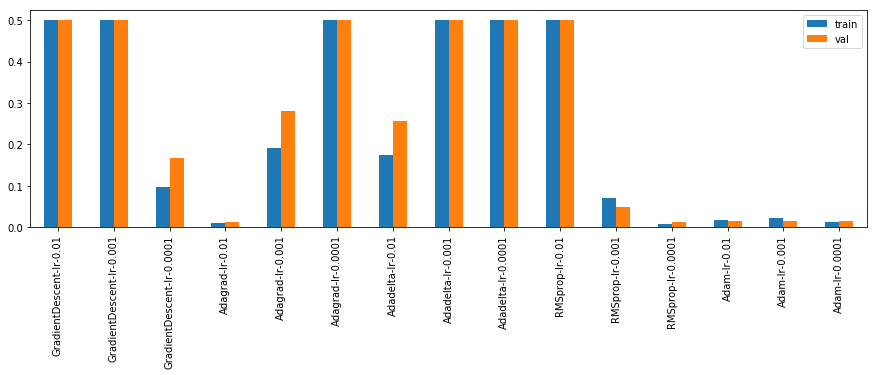

In [27]:
import pickle
import pandas as pd
if grid_search==True and save_search==True:
    f=open('img/opt_lr_loss_dfs','wb')
    pickle.dump(loss_dfs,f)
    f.close()
    f=open('img/opt_lr_loss_vals','wb')
    pickle.dump(loss_vals,f)
    f.close()
f=open('img/opt_lr_loss_vals','rb')
loss_vals=pickle.load(f)
f.close()

loss_vals=pd.DataFrame(loss_vals,index=['train','val','lr','act']).transpose()
loss_vals=loss_vals.loc[:,['train','val']]
loss_vals.fillna(0.5,inplace=True)
loss_vals[loss_vals>.5]=0.5
loss_vals.plot.bar(figsize=(15,4))

### Cross-validation Block
    Set > cross_val=True for executing cross validation.
    
    Below is the code for 3-fold cross validation over the whole train dataset.
    
    Function get_cross_val_errors:
            - input : n_fold,epoc,no_of_batch,lr,beta,act,opt_fun
            -output : dictionary of loss values, loss dataframes nth fold as keys.

In [28]:
realtime_plot=False
cross_val=False
n_fold=3
val_flag=True
from sklearn.model_selection import KFold 

def get_cross_val_errors(n_fold,epoc,no_of_batch,lr,beta,act,opt_fun):
        
    cr_loss_vals={}
    cr_loss_dfs={}
    kf = KFold(n_splits=n_fold)
    i=0
    for train_index,test_index in kf.split(_train.copy()):
        i=i+1
        _train_arr=np.array(_train.copy())
        _train_x=_train_arr[train_index].copy()
        _train_y=y_train[train_index].reshape(-1,1).copy()
        _val_x=_train_arr[test_index].copy()
        _val_y=y_train[test_index].reshape(-1,1).copy()
        
        print(i,'th Fold training....','train',_train_x.shape,'test',_val_x.shape)
        sp_data=[_train_x,_train_y,_val_x,_val_y]
        _,t_loss,v_loss=run_train_loop(epoc,batch_size,lr,beta,act,opt_fun,sp_data)
        mt_loss=np.mean(np.array(t_loss[-10:]))
        mv_loss=np.mean(np.array(v_loss[-10:]))
        cr_loss_df=pd.DataFrame({'train_loss':t_loss,'val_loss':v_loss})
        cr_loss_dfs['Fold'+str(i)]=cr_loss_df
        cr_loss_vals['Fold'+str(i)]=[mt_loss,mv_loss]
    return cr_loss_vals,cr_loss_dfs

batch_size=14
opt_fun='RMSprop'
act='none'
    
epoc=1000
lr=0.0001
beta=0.1

if cross_val==True:
            cr_loss_vals,cr_loss_dfs=get_cross_val_errors(n_fold,epoc,batch_size,lr,beta,act,opt_fun)


### Plot of saved Cross Validation error for 3-Folds  :

,train,val
Fold1,0.008937,0.021199
Fold2,0.008033,0.022006
Fold3,0.008977,0.016010


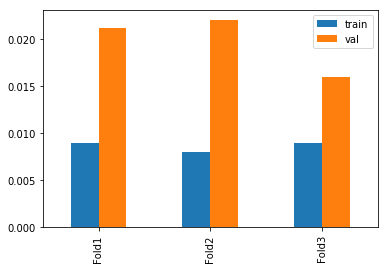

In [29]:
import pickle
import pandas as pd
if cross_val=='_True':
    f=open('img/cr_loss_dfs','wb')
    pickle.dump(cr_loss_dfs,f)
    f.close()
    f=open('img/cr_loss_vals','wb')
    pickle.dump(cr_loss_vals,f)
    f.close()
f=open('img/cr_loss_vals','rb')
cr_loss_vals=pickle.load(f)
f.close()
err_df=pd.DataFrame(cr_loss_vals,index=['train','val']).transpose()
err_df.plot.bar()
#err_df.mean()
err_df

### Transfer learning block : For using the trained weights later
1. 'save_weights' function dumps the trained weights.
2. 'load_weights' function reads the dumped weights and biases
3. 'build_and_predict' function rebuilds the model and sets the pre-trained weights and biases for prediction.

In [30]:
import pickle
def save_weights(model):
    wts,bias=model.get_weights()
    inputs_test={model.x:np.array(_test)}
    wt,bs=model.sess.run((wts,bias))

    f=open("trained_params","wb")
    pickle.dump([wt,bs],f)
    f.close()
def load_weights():
    f=open("trained_params","rb")
    [wt,bs]=pickle.load(f)
    f.close()
    return wt,bs
def build_and_predict(test_data,wt,bs):
    tf.reset_default_graph()

    N=ANN(act,opt_fun)
    N.set_weights(wt,bs)
    tx = tf.placeholder(tf.float64, shape=[None, _train.shape[1]])
    t_out=N.model_predict(tx)

    t_sess = tf.Session()
    init = tf.global_variables_initializer()
    t_sess.run(init)

    inputs_test={tx:np.array(test_data)}
    res = t_sess.run((t_out),feed_dict=inputs_test)
    res = res.reshape(-1)
    return res

### Uncomment the save_weights function for saving the trained weights

In [34]:
#save_weights(model=ANN_Model)
wt,bs=load_weights()
result2=build_and_predict(_test,wt,bs)

### Submission block
Creates .csv file for kaggle submission

In [33]:
rres_exp=np.exp(result1)
print(len(rres_exp))
data='Id,SalePrice\n'
Id=1461
for row in rres_exp:
    data+=str(Id)+','+str(row)+'\n'
    Id+=1
file=open('Assignment_4_ANN_Low_lavel_API_final.csv','w')
file.write(data)
file.close()

1459


### Results :

###  Kaggle Score for ANN (trained with 99% train data) : 0.12076 , below is the screenshot
![title](img/Kaggle_ANN_2.png)<br>

### Kaggle Score for Linear regression with l2 regulariaion : 0.11624 , Position 669 (when submitted) ,Screenshot is below
![title](img/Kaggle_lr.png)<br>

### Discussion and Conclusion:
1. Linear Regression result was the best one about 0.11624
2. ANN result was about 0.12076 and screenshot is displayed above.
3. Linear Regression was used for checking  data preprocessing steps effectiveness only.
4. Linear regression with L2 Regularization performed best, where alpha value was found by grid search.
5. Xgboost,SVM and gradient boosting was tried also which resulted error of about (0.12-0.13) 

### Refferences :
    The following tutorials were useful for hyperparameter tuning.
        1. http://ruder.io/optimizing-gradient-descent/
        2. https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-
           machine-learning-part-1-of-3-6dca2f71b159
        3. https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c
        4. https://towardsdatascience.com/preventing-deep-neural-network-from-
           overfitting-953458db800

<br>__ID__ : A1803 <br>
__Date of Submission__ : 03/02/2019 